In [16]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data from excel file
data = pd.read_excel('./COVID-19-geographic-disbtribution-worldwide-2020-05-11.xlsx')

In [3]:
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-05-11,11,5,2020,369,5,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-05-10,10,5,2020,255,6,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-05-09,9,5,2020,215,3,Afghanistan,AF,AFG,37172386.0,Asia
3,2020-05-08,8,5,2020,171,2,Afghanistan,AF,AFG,37172386.0,Asia
4,2020-05-07,7,5,2020,168,9,Afghanistan,AF,AFG,37172386.0,Asia


In [4]:
data.describe()

,day,month,year,cases,deaths,popData2018
count,16322.000000,16322.000000,16322.000000,16322.000000,16322.000000,1.613100e+04
mean,15.303149,3.318772,2019.995895,248.959993,17.292244,5.292984e+07
std,9.023562,1.339598,0.063940,1652.715429,125.366519,1.789120e+08
min,1.000000,1.000000,2019.000000,-2461.000000,0.000000,1.000000e+03
25%,7.000000,3.000000,2020.000000,0.000000,0.000000,2.781677e+06
50%,15.000000,4.000000,2020.000000,2.000000,0.000000,9.768785e+06
75%,23.000000,4.000000,2020.000000,35.000000,1.000000,3.705886e+07
max,31.000000,12.000000,2020.000000,48529.000000,4928.000000,1.392730e+09


In [5]:
# we need to sort the data from the begining of the pandemic
data = data.sort_values(by=['year', 'month', 'day'], ascending=True)

In [6]:
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
122,2019-12-31,31,12,2019,0,0,Afghanistan,AF,AFG,37172386.0,Asia
314,2019-12-31,31,12,2019,0,0,Algeria,DZ,DZA,42228429.0,Africa
713,2019-12-31,31,12,2019,0,0,Armenia,AM,ARM,2951776.0,Europe
896,2019-12-31,31,12,2019,0,0,Australia,AU,AUS,24992369.0,Oceania
1029,2019-12-31,31,12,2019,0,0,Austria,AT,AUT,8847037.0,Europe


In [7]:
# get values used in  SCAT (Simple Curve Approximation Tool) 
def get_scat_values(data, country_code, w=20):
    m = data.loc[data['countryterritoryCode'] == country_code].cases.max()
    p = data.loc[data['countryterritoryCode'] == country_code]['cases'].argmax()
    return (m, p, w)

In [8]:
m, p, w = get_scat_values(data, 'MEX')
print(f'Maximum number of cases: {m}')
print(f'Peak day: {p}')
print(f'Curve widht: {w}')

Maximum number of cases: 1982
Peak day: 121
Curve widht: 20


In [78]:
# Now we can use SCAT
def calculate_SCAT(params, contries):
    dfs = dict()
    for code in contries:
        m, p, w = get_scat_values(data, code)
        df = data.loc[data['countryterritoryCode'] == code].copy()
        df['counter'] = range(len(df))
        df['scat'] = m * np.exp( - ((np.power((df.counter + 1)  - p, 2)) / (2 * np.power(w, 2) )))
        dfs[code] = df
    return dfs
        

In [79]:
dfs = calculate_SCAT((m, p, w), ['MEX', 'BRA', 'ITA'])

In [80]:
# Mexico curve
dfs['MEX'].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,counter,scat
9906,2019-12-31,31,12,2019,0,0,Mexico,MX,MEX,126190788.0,America,0,0.000030
9905,2020-01-01,1,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,1,0.000041
9904,2020-01-02,2,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,2,0.000055
9903,2020-01-03,3,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,3,0.000073
9902,2020-01-04,4,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,4,0.000098


In [81]:

dfs['MEX'].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,counter,scat
9906,2019-12-31,31,12,2019,0,0,Mexico,MX,MEX,126190788.0,America,0,0.000030
9905,2020-01-01,1,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,1,0.000041
9904,2020-01-02,2,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,2,0.000055
9903,2020-01-03,3,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,3,0.000073
9902,2020-01-04,4,1,2020,0,0,Mexico,MX,MEX,126190788.0,America,4,0.000098


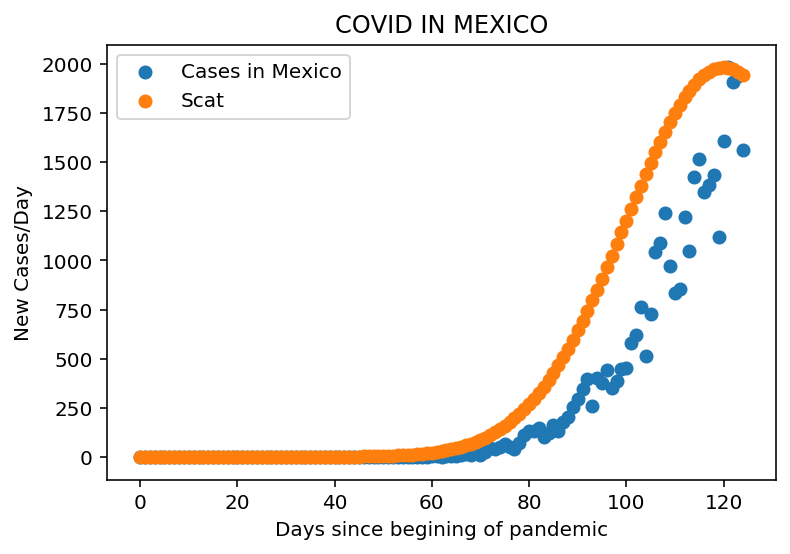

In [91]:
plot = plt.figure()
ax1 = plot.add_subplot(111)

ax1.scatter(dfs['MEX'].counter, dfs['MEX'].cases, label='Cases in Mexico')
ax1.scatter(dfs['MEX'].counter, dfs['MEX'].scat, label='Scat')
plt.legend(loc='upper left');
plt.title('COVID IN MEXICO')
plt.xlabel('Days since begining of pandemic')
plt.ylabel('New Cases/Day')
plt.show()

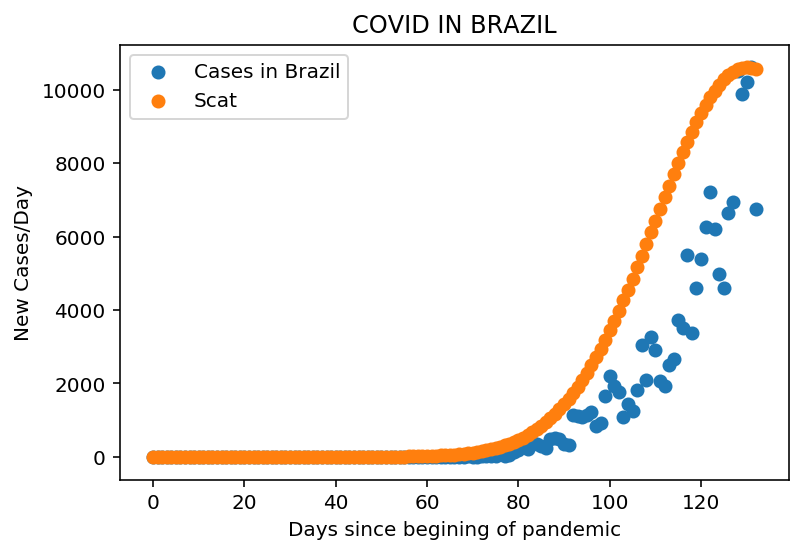

In [92]:
plot = plt.figure()
ax1 = plot.add_subplot(111)

ax1.scatter(dfs['BRA'].counter, dfs['BRA'].cases, label='Cases in Brazil')
ax1.scatter(dfs['BRA'].counter, dfs['BRA'].scat, label='Scat')
plt.legend(loc='upper left');
plt.title('COVID IN BRAZIL')
plt.xlabel('Days since begining of pandemic')
plt.ylabel('New Cases/Day')
plt.show()

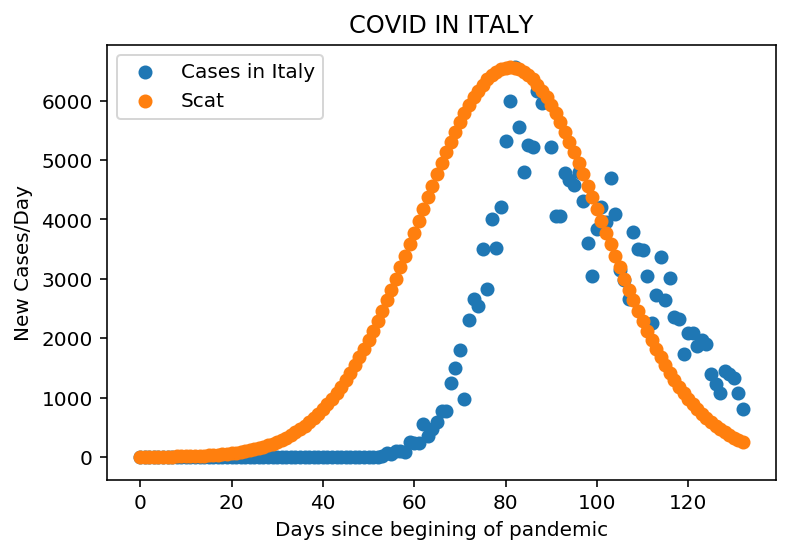

In [93]:
plot = plt.figure()
ax1 = plot.add_subplot(111)

ax1.scatter(dfs['ITA'].counter, dfs['ITA'].cases, label='Cases in Italy')
ax1.scatter(dfs['ITA'].counter, dfs['ITA'].scat, label='Scat')
plt.legend(loc='upper left');
plt.title('COVID IN ITALY')
plt.xlabel('Days since begining of pandemic')
plt.ylabel('New Cases/Day')

plt.show()